# 0.0 IMPORTS

In [1]:
#!pip install lightgbm

In [2]:
#! pip install xgboost

In [50]:
import warnings
import xgboost               as xgb
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import lightgbm              as lgb
from sklearn.preprocessing   import LabelEncoder
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics         import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold


warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="pastel")

## 0.1. FUNCTIONS

In [2]:
def faixa_etaria(x):
    if x <= 35:
        return 'Adulto-1'
    elif x > 35 and x <= 45:
        return 'Adulto-2'
    elif x > 45 and x <= 60:
        return 'Adulto-3'
    else:
        return 'Idoso'

## 0.2. LOADING DATA

In [3]:
df = pd.read_csv('heart.csv')

# 1.0. DATA DESCRIPTION

In [4]:
df1 = df.copy()

## 1.1. RENAME COLUMNS

In [5]:
columns_old = df1.columns
columns = lambda x: x.title()
columns_new = list(map(columns,columns_old))

# rename
df1.columns = columns_new

## 1.2. DATA DIMENSIONS

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 918
Number of Cols: 12


## 1.3. DATA TYPES

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   Chestpaintype   918 non-null    object 
 3   Restingbp       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   Fastingbs       918 non-null    int64  
 6   Restingecg      918 non-null    object 
 7   Maxhr           918 non-null    int64  
 8   Exerciseangina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  St_Slope        918 non-null    object 
 11  Heartdisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## 1.4. CHECK NA

In [8]:
df1.isnull().sum()

Age               0
Sex               0
Chestpaintype     0
Restingbp         0
Cholesterol       0
Fastingbs         0
Restingecg        0
Maxhr             0
Exerciseangina    0
Oldpeak           0
St_Slope          0
Heartdisease      0
dtype: int64

## 1.5. DESCRIPTIVE STATISTICS

In [9]:
df1.describe()

,Age,Restingbp,Cholesterol,Fastingbs,Maxhr,Oldpeak,Heartdisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Percebe-se que alguns atributos numéricos tem como o valor minimo 0. Isto será alterado na segunda iteração do projeto.

# 2.0. EXPLORATORY ANALYSIS

In [10]:
df2 = df1.copy()

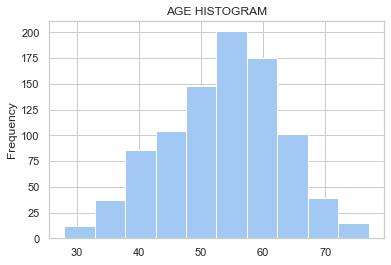

In [11]:
plt.title('AGE HISTOGRAM')
df2['Age'].plot(kind='hist');

Percebe-se uma distribuição normal.

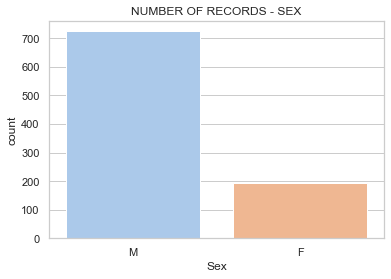

In [12]:
plt.title('NUMBER OF RECORDS - SEX')
sns.countplot(x='Sex', data=df2)
plt.show();

Há mais registros masculinos.

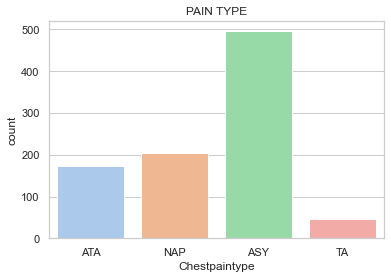

In [13]:
plt.title('PAIN TYPE')
sns.countplot(x='Chestpaintype', data=df2)
plt.show();

Tipos de dores: 
- TA: Angina Típica
- ATA: Angina Atípica 
- NAP: Dor Não Anginosa 
- ASY: Assintomática

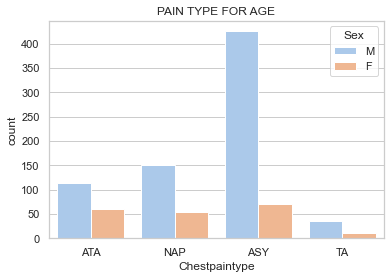

In [14]:
plt.title('PAIN TYPE FOR AGE')
sns.countplot(x='Chestpaintype', data=df2, hue='Sex')
plt.show();

Tipos de dores por sexo.

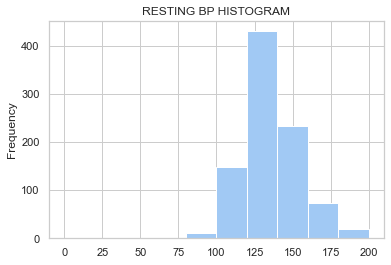

In [15]:
plt.title('RESTING BP HISTOGRAM')
df2['Restingbp'].plot(kind='hist');

Pressão arterial em repouso.

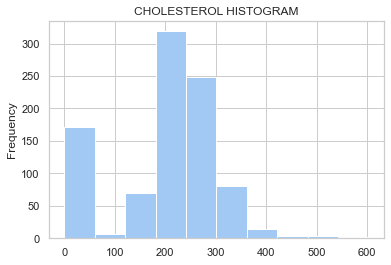

In [16]:
plt.title('CHOLESTEROL HISTOGRAM')
df2['Cholesterol'].plot(kind='hist');

Distribuição do colesterol.

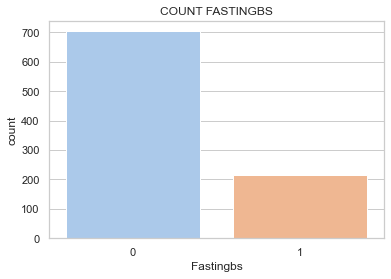

In [17]:
plt.title('COUNT FASTINGBS')
sns.countplot(x='Fastingbs', data=df2)
plt.show();

glicemia em jejum [1: se FastingBS > 120 mg/dl, 0: caso contrário]

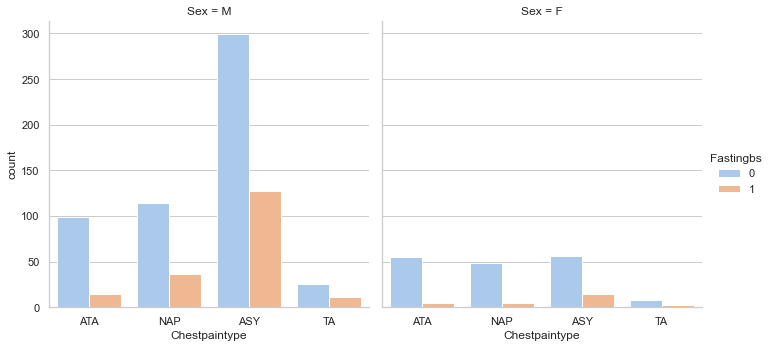

In [18]:
sns.catplot(x='Chestpaintype',data=df2, hue='Fastingbs', col='Sex', kind="count")
plt.show();

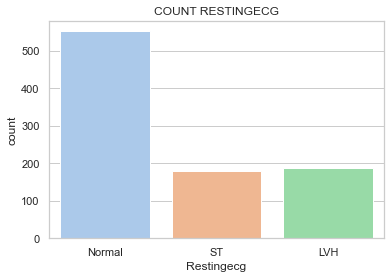

In [19]:
plt.title('COUNT RESTINGECG')
sns.countplot(x='Restingecg', data=df2)
plt.show();

resultados do eletrocardiograma de repouso: 
- Normal: normal, 
- ST: com anormalidade da onda ST-T (inversões da onda T e/ou elevação ou depressão do ST > 0,05 mV), 
- LHV: mostrando provável ou definitiva hipertrofia ventricular esquerda pelos critérios de Estes

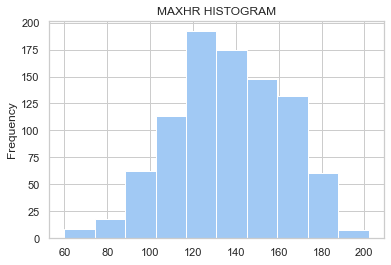

In [20]:
plt.title('MAXHR HISTOGRAM')
df2['Maxhr'].plot(kind='hist');

frequência cardíaca máxima alcançada: Valor numérico entre 60 e 202.

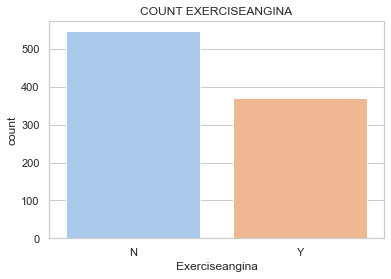

In [21]:
plt.title('COUNT EXERCISEANGINA')
sns.countplot(x='Exerciseangina', data=df2)
plt.show();

angina induzida por exercício 
- Y: Sim
- N: Não

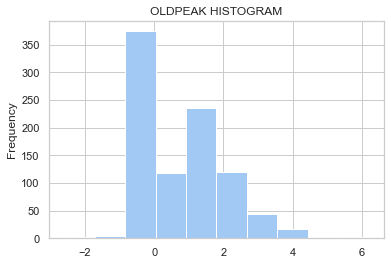

In [22]:
plt.title('OLDPEAK HISTOGRAM')
df2['Oldpeak'].plot(kind='hist');

ST: Valor numérico medido em depressão

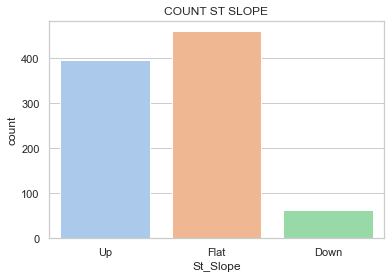

In [23]:
plt.title('COUNT ST SLOPE')
sns.countplot(x='St_Slope', data=df2)
plt.show();

a inclinação do segmento ST do exercício de pico: 
- Up: upsloping
- Flat: flat
- Down: downsloping

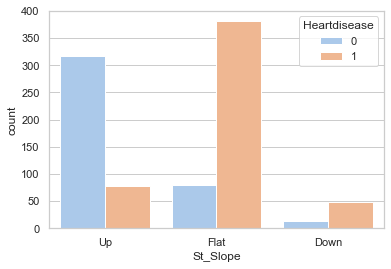

In [24]:
sns.countplot(x='St_Slope', data=df2, hue='Heartdisease')
plt.show();

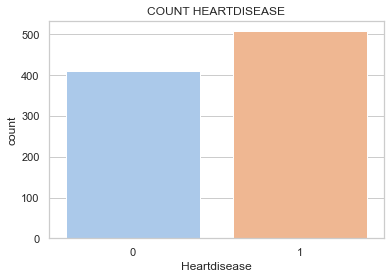

In [25]:
plt.title('COUNT HEARTDISEASE')
sns.countplot(x='Heartdisease', data=df2)
plt.show();

classe de saída 
- 1: doença cardíaca
- 0: normal

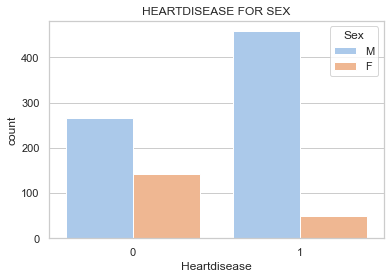

In [26]:
plt.title('HEARTDISEASE FOR SEX')
sns.countplot(x='Heartdisease', data=df2, hue='Sex')
plt.show();

Nesta base de dados, os homens - de forma proporcional- possuem mais casos de doença cardíaca.

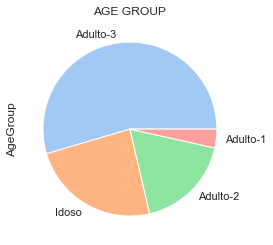

In [27]:
df2['AgeGroup'] = df2['Age'].apply(faixa_etaria)
plt.title('AGE GROUP')
df2['AgeGroup'].value_counts().plot(kind='pie');

Percebe-se que existem mais pessoas entre 45 a 60 anos.

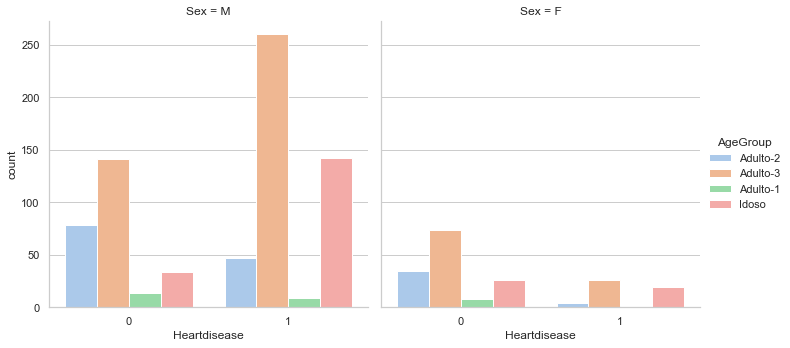

In [28]:
sns.catplot(x='Heartdisease',data=df2, hue='AgeGroup', col='Sex', kind="count")
plt.show();

Idosos tem uma chance maior de desenvolver alguma doença cardio vascular.

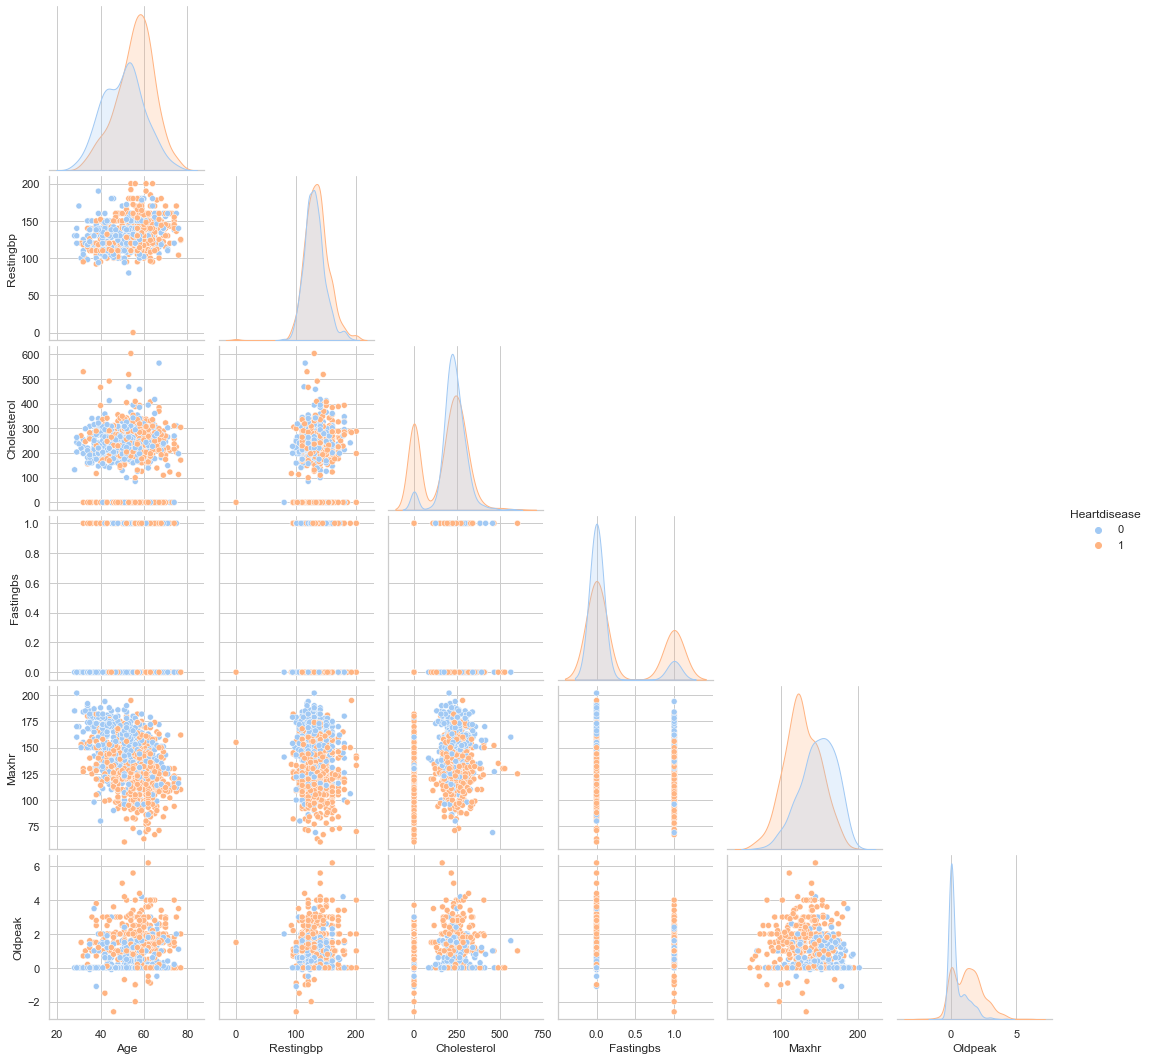

In [29]:
sns.pairplot(df2,hue='Heartdisease',corner=True)
plt.show();

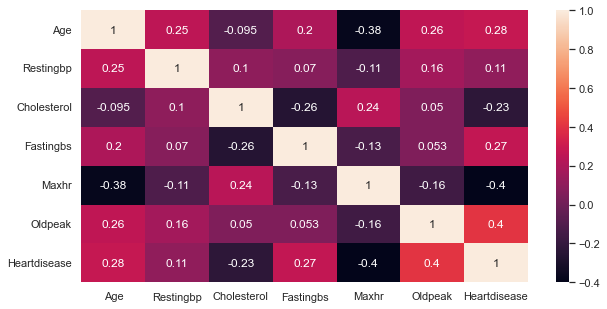

In [30]:
plt.figure(figsize=(10, 5))
sns.heatmap(df2.corr( method='pearson' ), annot=True)
plt.show();

# 2.0 FEATURE ENGINEERING

In [31]:
df3 = df1.copy()

In [32]:
le = LabelEncoder()

In [33]:
# column Sex
df3['Sex'] = df2['Sex'].map({'M': 0, 'F': 1})

# column Exerciseangina
df3['Exerciseangina'] = df2['Exerciseangina'].map({'N': 0, 'Y': 1})

# column Chestpaintype
df3['Chestpaintype'] = le.fit_transform(df3['Chestpaintype'])

# column Restingecg	
df3['Restingecg'] = le.fit_transform(df3['Restingecg'])

# column St_Slope
df3['St_Slope'] = le.fit_transform(df3['St_Slope'])

In [34]:
df3

,Age,Sex,Chestpaintype,Restingbp,Cholesterol,Fastingbs,Restingecg,Maxhr,Exerciseangina,Oldpeak,St_Slope,Heartdisease
0,40,0,1,140,289,0,1,172,0,0.0,2,0
1,49,1,2,160,180,0,1,156,0,1.0,1,1
2,37,0,1,130,283,0,2,98,0,0.0,2,0
3,48,1,0,138,214,0,1,108,1,1.5,1,1
4,54,0,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,1,132,0,1.2,1,1
914,68,0,0,144,193,1,1,141,0,3.4,1,1
915,57,0,0,130,131,0,1,115,1,1.2,1,1
916,57,1,1,130,236,0,0,174,0,0.0,1,1


# 3.0. DATA PREPARATION

In [55]:
X = df3.drop(['Heartdisease'], axis = 1)
y = df3['Heartdisease']
# scale
sc = StandardScaler()
X = sc.fit_transform(X)

In [56]:
# split train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# 4.0. MODELS

## 4.1. RANDOMFOREST

In [40]:
clf = RandomForestClassifier(n_estimators = 10,criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

In [41]:
accuracy_score(y_test, predict)

0.8514492753623188

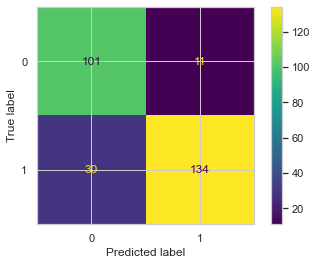

In [42]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

In [43]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       112
           1       0.92      0.82      0.87       164

    accuracy                           0.85       276
   macro avg       0.85      0.86      0.85       276
weighted avg       0.86      0.85      0.85       276



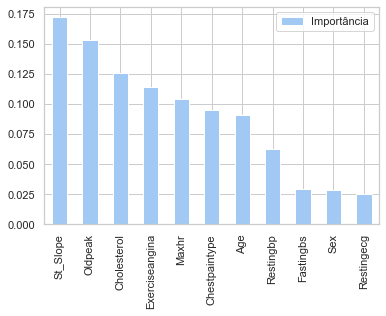

In [44]:
columns = ['Age','Sex', 'Chestpaintype', 'Restingbp', 'Cholesterol', 'Fastingbs', 'Restingecg', 'Maxhr', 'Exerciseangina', 'Oldpeak', 'St_Slope']
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = columns,
                                   columns=['Importância']).sort_values('Importância', ascending=False)
feature_importances.plot(kind='bar')
plt.show()

## 4.2. LGBM

In [45]:
Model_lgb=lgb.LGBMClassifier()
Model_lgb.fit(X_train,y_train)
predict=Model_lgb.predict(X_test)

In [46]:
accuracy_score(y_test, predict)

0.8623188405797102

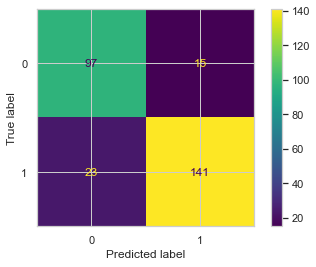

In [47]:
plot_confusion_matrix(Model_lgb, X_test, y_test)
plt.show()

In [48]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       112
           1       0.90      0.86      0.88       164

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.87      0.86      0.86       276



## 4.3. XGBOOST

In [51]:
xg = xgb.XGBClassifier(eval_metric = ["error"], random_state=42)
xg.fit(X_train,y_train)
predict = xg.predict(X_test)

In [59]:
accuracy_score(y_test, predict)

0.8514492753623188

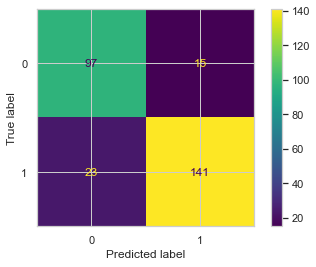

In [60]:
plot_confusion_matrix(Model_lgb, X_test, y_test)
plt.show()

In [52]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       112
           1       0.90      0.84      0.87       164

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.86      0.85      0.85       276



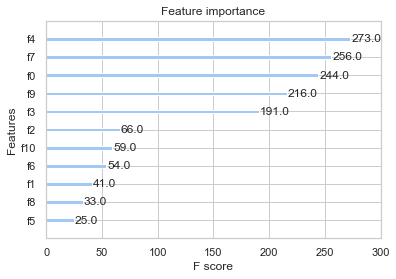

In [52]:
xgb.plot_importance(xg);

## 4.4. GRIDSEACHCV

In [62]:
params = {
    'n_estimators' : [50, 200, 300, 400],
    'learning_rate' : [0.1, 0.02, 0.04],
    'max_depth' : [2, 3, 5],
    'min_child_weight': [1, 5, 10],
    'gamma' : [0, 0.25, 1],
    
    
}

grid_search = GridSearchCV(estimator= xgb.XGBClassifier(eval_metric = ["error"], n_jobs=-1), param_grid = params, cv=5, scoring='roc_auc')
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

{'gamma': 0.25, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200}
0.9105899399122122


# 5.0. CROSS VALIDATION

In [57]:
result = []
for i in range(10):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    clf =xgb.XGBClassifier(gamma=0.25, learning_rate=0.02, max_depth= 3, min_child_weight=10, n_estimators=200, eval_metric = ["error"], n_jobs=-1)
    scores = cross_val_score(clf, X, y, cv=kfold)
    result.append(scores.mean())

In [58]:
result = pd.DataFrame(data=result, columns=['Resultado'])
result.describe()

,Resultado
count,10.000000
mean,0.869495
std,0.004233
min,0.864931
25%,0.867075
50%,0.868210
75%,0.870894
max,0.879085
